In [2]:
import sys
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.model_selection import train_test_split

# visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# seaborn styling default
sns.set_theme(style='darkgrid')

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv('derived_data/combined_dataset.csv', index_col = [0])

## Visiualise the Data

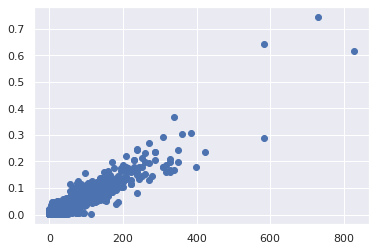

In [27]:
plt.scatter(df['Actiwatch activity counts'], df['Apple Watch ENMO'])

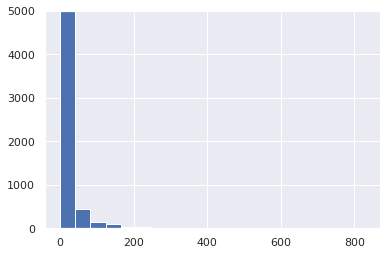

In [56]:

n_bins = 20

# Generate two normal distributions
dist1 = df['Actiwatch activity counts']
plt.ylim(0,5000)
plt.hist(dist1, bins = n_bins)
plt.show()

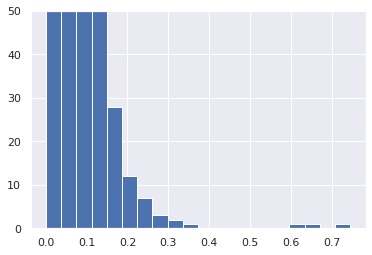

In [6]:
n_bins = 20

# Generate two normal distributions
dist1 = df['Apple Watch ENMO']
plt.hist(dist1, bins = n_bins)
plt.show()

### Sample stratify Data for model building


In [56]:
df_x = df[['Apple Watch ENMO', 'ELMO_before','ELMO_after']].copy()
df_y  = df[['Actiwatch activity counts']].copy()
nums_x = df_x.to_numpy()
nums_y = df_y.to_numpy()

In [57]:
X_train, X_test, y_train, y_test = train_test_split(nums_x, nums_y, test_size=0.33, random_state=42)
X_train = X_train.astype('float64')
y_train = y_train.astype('int')
X_test = X_test.astype('float64')
y_test = y_test.astype('int')

### Define functions for testing

Applies the  Philips’ Actiware software algorithm to a dataframe and returns a new dataframe with a column predicted_actiwatch whihc contains the totals counts for the given row

In [58]:
def phillips_alogrithn(df):
    for index, row in df.iterrows():
        if index <= 8 or index >= len(df.index)-8:
            continue

        #part 1
        p1 = 0
        for i in range(-8,-4):
            j = index + i
            p1 = p1 + df.loc[j]['predicted_actiwatch']

        #part 2
        p2 = 0
        for i in range(-4,0):
            j = index + i
            p2 = p2 + df.loc[j]['predicted_actiwatch']

        #part 3
        p3 = 0
        for i in range(1,5):
            j = index + i
            p3 = p3 + df.loc[j]['predicted_actiwatch']

        #part 4
        p4 = 0
        for i in range(5,9):
            j = index + i
            p4 = p4 + df.loc[j]['predicted_actiwatch']

        #Calculate total counts
        df.at[index, 'total_counts'] = 0.04*p1 + 0.2*p2 + 4*df.loc[index]['predicted_actiwatch'] + 0.2*p3 + 0.04*p4

    return df



Simple function given a threshold and total count returns 1 for awake and zero for sleep

In [59]:
def predict_sleep_awake(row, threshold):
    if row['total_counts'] <= threshold:
        return 0
    else:
        return 1


    

Given a patient file, sklearn model and threshold returns a dataframe with sleep/wake prediction for patient

In [60]:
def test_model_on_patient(patientFile, model, threshold):
    #import patient file
    import_df = pd.read_csv('derived_data/'+ patientFile +'.csv')

    #Grab fields required for prediction
    test_df = import_df[['Apple Watch ENMO','ELMO_before','ELMO_after']].copy()
    test_nums = test_df.to_numpy()

    #predict actiwatch counts
    predict = model.predict(test_nums).astype('int')
    import_df['predicted_actiwatch']= predict

    #determine total counts
    predicted_df = phillips_alogrithn(import_df)

    #determine sleep or awake
    predicted_df['predicted_sleep'] = predicted_df.apply (lambda row: predict_sleep_awake(row, threshold), axis=1)

    return import_df

   


Uses confunsion matrix tp determine accuracy

In [61]:
def check_accuracy(df):
    #sleep is zero, awake is one
    df_accuracy = df.dropna(subset=['Actiware classification']).copy()

    TP=0
    TN=0
    FP=0
    FN=0

    for index, row in df_accuracy.iterrows():
        if row['Actiware classification'] == 1 and row['predicted_sleep'] == 1:
            TN+=1
        if row['Actiware classification'] == 1 and row['predicted_sleep'] == 0:
            FP+=1
        if row['Actiware classification'] == 0 and row['predicted_sleep'] == 0:
            TP+=1
        if row['Actiware classification'] == 0 and row['predicted_sleep'] == 1:
            FN+=1
    
    accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
    return accuracy

### Test Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
model = LinearRegression().fit(X_train, y_train)

In [22]:
r_sq = model.score(X_test, y_test)
print(f"coefficient of determination: {r_sq}")


coefficient of determination: 0.23169330236353414


In [62]:
test_df = test_model_on_patient('P03_N1_filtered', model,40)
check_accuracy(test_df)

98.64537977745525

### Test on Random Forest

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [65]:
regressor.fit(X_train, y_train) 

RandomForestRegressor(random_state=0)

In [66]:
r_sq_2 = regressor.score(X_test, y_test)
print(f"coefficient of determination: {r_sq_2}")

coefficient of determination: 0.8540679001140825


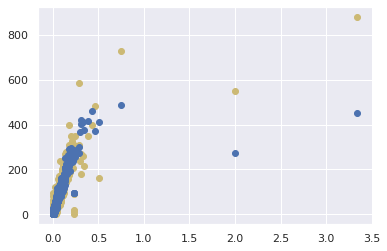

In [67]:
plt.plot(X_test[:, 0],y_test, 'yo', X_test[:, 0],regressor.predict(X_test), 'bo')

Test on patient

In [68]:
test_df = test_model_on_patient('P03_N1_filtered', regressor,40)
check_accuracy(test_df)

98.98403483309144

### Test on Naive Bayes

In [69]:
from sklearn.naive_bayes import GaussianNB

In [70]:
gnb = GaussianNB()

In [72]:
gnb.fit(X_train, y_train)


GaussianNB()

In [73]:
r_sq_3 = gnb.score(X_test, y_test)
print(f"coefficient of determination: {r_sq_3}")

coefficient of determination: 0.9154417453195111


Test on patient

In [74]:
test_df = test_model_on_patient('P03_N1_filtered', gnb,40)
check_accuracy(test_df)

98.69375907111755

### Test on SVM

In [75]:
from sklearn import svm

In [76]:
regr = svm.SVR()
regr.fit(X_train, y_train)

SVR()

In [77]:
r_sq_4 = regr.score(X_test, y_test)
print(f"coefficient of determination: {r_sq_4}")

coefficient of determination: 0.4841984690962887


Test on patient

In [78]:
test_df = test_model_on_patient('P03_N1_filtered', regr,40)
check_accuracy(test_df)

98.35510401548137